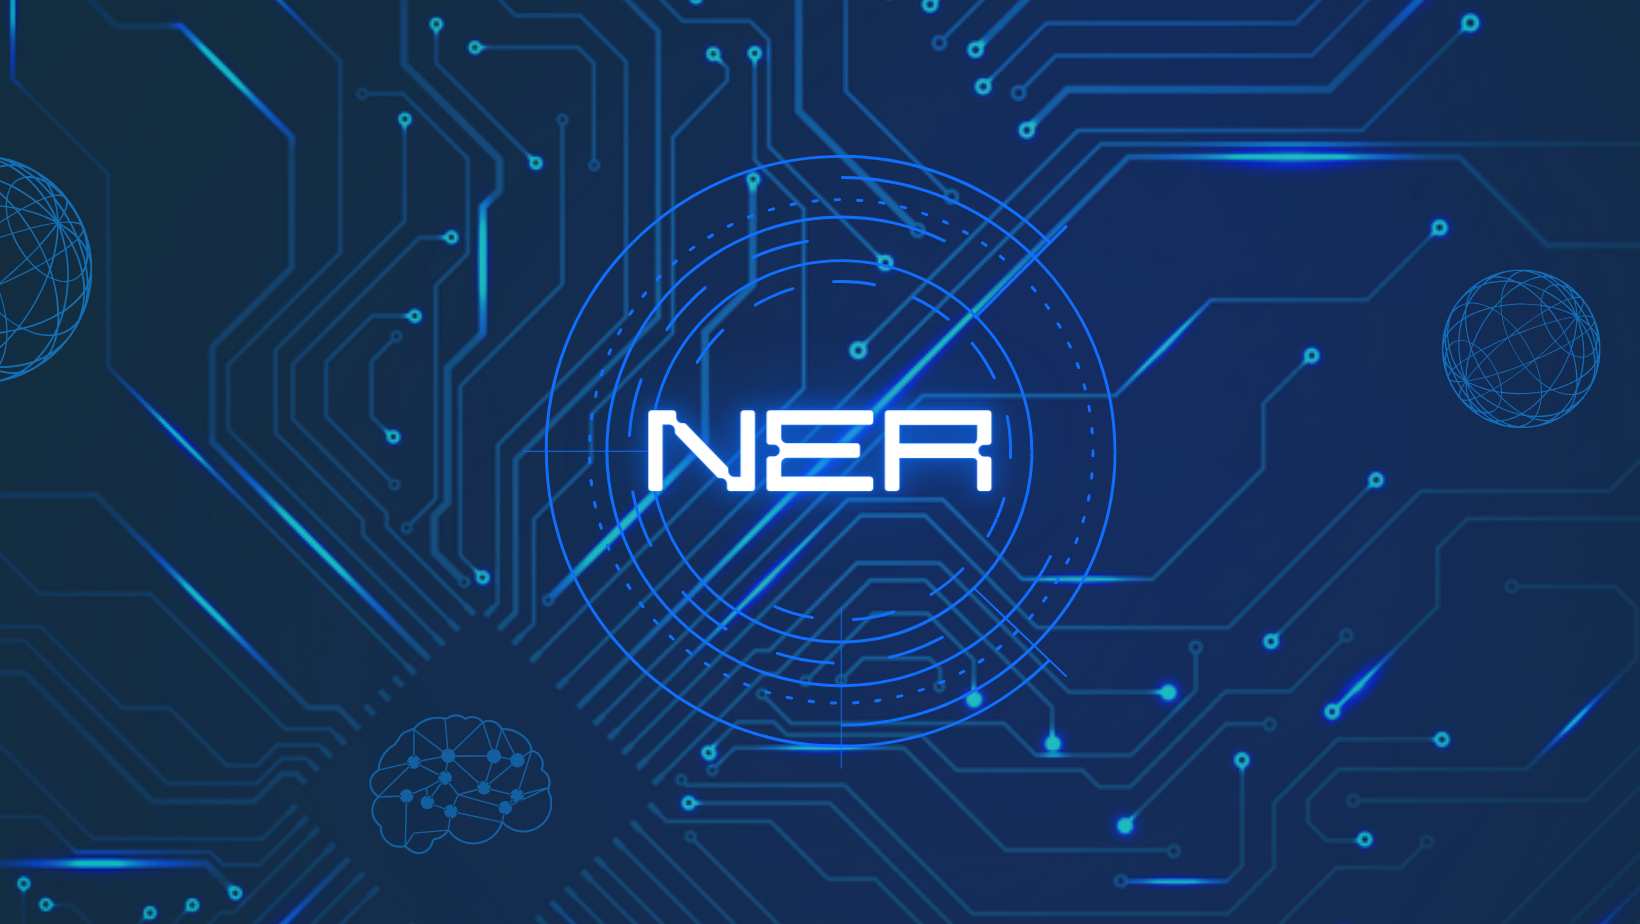

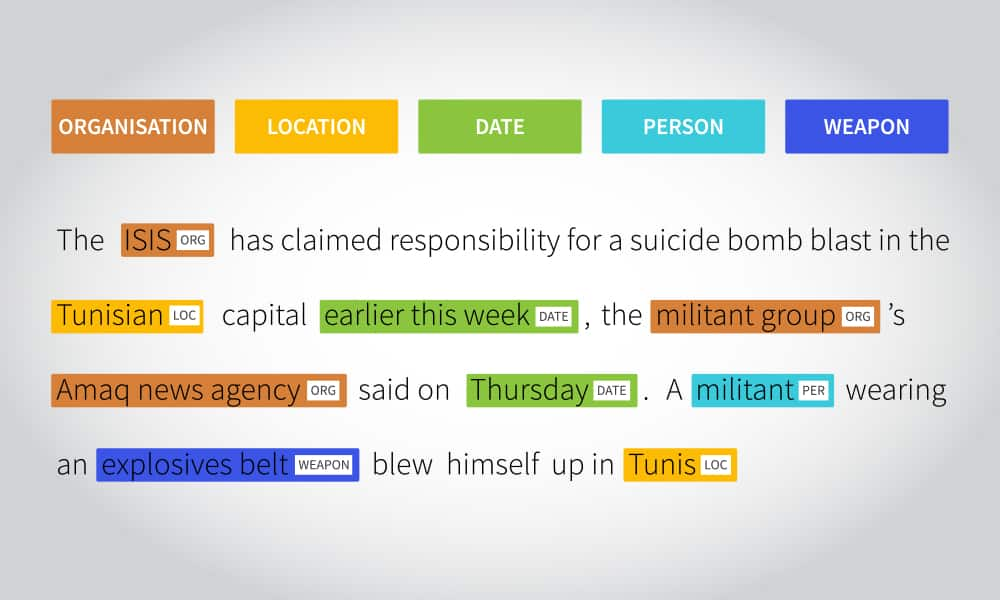

# **Task 4: Named Entity Recognition (NER) from News Articles**


Description:



*   Dataset (Recommended): CoNLL003 (Kaggle)
*   Identify named entities (like people, locations, and organizations) from article content
*   Use rule-based and model-based NER approaches
*   Highlight and categorize extracted entities in the text


# **BERT-based Named Entity Recognition (NER) model**

In [2]:
!pip install seqeval==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=aaa7fdd024d3bf7398334dcd542f8d4db8b6c708626138ec817dab16a146a37d
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


This dataset is divided into train.txt, test.txt and valid.txt
The Tokens are labeled under one of the following tags
[
I-LOC
B-ORG
O
B-PER
I-PER
I-MISC
B-MISC
I-ORG
B-LOC]

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizerFast,
    BertModel,
    get_scheduler
)

from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

In [4]:
class CFG:
    model_name = "bert-base-cased"
    max_len = 128
    train_batch_size = 16
    valid_batch_size = 16
    lr = 5e-5
    epochs = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"

# Label mapping (CoNLL2003)
label_list = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG",
              "B-LOC", "I-LOC", "B-MISC", "I-MISC"]

label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

tokenizer = BertTokenizerFast.from_pretrained(CFG.model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# ====================================================
# 📌 Cell 4: Dataset loader
# ====================================================
def read_conll_data(filepath):
    texts, tags = [], []
    words, labels = [], []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            if line.startswith("-DOCSTART-") or line.strip() == "":
                if words:
                    texts.append(words)
                    tags.append(labels)
                    words, labels = [], []
                continue
            splits = line.strip().split()
            words.append(splits[0])
            labels.append(splits[-1])
        if words:  # last sentence
            texts.append(words)
            tags.append(labels)
    return texts, tags

train_texts, train_tags = read_conll_data("/content/train.txt")
valid_texts, valid_tags = read_conll_data("/content/valid.txt")
test_texts, test_tags   = read_conll_data("/content/valid.txt")

print("✅ Loaded dataset:", len(train_texts), len(valid_texts), len(test_texts))

✅ Loaded dataset: 14041 3250 3250


In [12]:
class NERDataset(Dataset):
    def __init__(self, texts, tags, tokenizer, label2id, max_len):
        self.encodings = encode_examples(texts, tags, tokenizer, label2id, max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

train_dataset = NERDataset(train_texts, train_tags, tokenizer, label2id, CFG.max_len)
valid_dataset = NERDataset(valid_texts, valid_tags, tokenizer, label2id, CFG.max_len)

train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size)

In [13]:
class NERModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(NERModel, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))
        return loss, logits

model = NERModel(CFG.model_name, len(label2id)).to(CFG.device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
num_training_steps = len(train_loader) * CFG.epochs
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [15]:
def train_fn(model, dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(CFG.device)
        attention_mask = batch["attention_mask"].to(CFG.device)
        labels = batch["labels"].to(CFG.device)

        loss, _ = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def eval_fn(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(CFG.device)
            attention_mask = batch["attention_mask"].to(CFG.device)
            labels = batch["labels"].to(CFG.device)

            loss, logits = model(input_ids, attention_mask, labels)
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)

            for i in range(len(labels)):
                pred_labels, true_l = [], []
                for j in range(len(labels[i])):
                    if labels[i][j] != -100:
                        pred_labels.append(id2label[predictions[i][j].item()])
                        true_l.append(id2label[labels[i][j].item()])
                preds.append(pred_labels)
                true_labels.append(true_l)

    f1 = f1_score(true_labels, preds)
    return total_loss / len(dataloader), f1, classification_report(true_labels, preds)

train_losses = []
valid_losses = []
valid_f1_scores = []

for epoch in range(CFG.epochs):
    train_loss = train_fn(model, train_loader)
    valid_loss, f1, report = eval_fn(model, valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_f1_scores.append(f1)
    print(f"Epoch {epoch+1}/{CFG.epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | F1: {f1:.4f}")
    print(report)

Epoch 1/2 | Train Loss: 0.0919 | F1: 0.9319
              precision    recall  f1-score   support

         LOC       0.96      0.95      0.96      1837
        MISC       0.84      0.88      0.86       922
         ORG       0.90      0.91      0.91      1341
         PER       0.96      0.97      0.96      1836

   micro avg       0.93      0.94      0.93      5936
   macro avg       0.91      0.93      0.92      5936
weighted avg       0.93      0.94      0.93      5936

Epoch 2/2 | Train Loss: 0.0219 | F1: 0.9462
              precision    recall  f1-score   support

         LOC       0.97      0.96      0.97      1837
        MISC       0.88      0.91      0.89       922
         ORG       0.91      0.93      0.92      1341
         PER       0.97      0.97      0.97      1836

   micro avg       0.94      0.95      0.95      5936
   macro avg       0.93      0.94      0.94      5936
weighted avg       0.94      0.95      0.95      5936



In [20]:
def predict_sentence(sentence, tokenizer, model, id2label, max_len=128):
    model.eval()
    tokens = sentence.split()

    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_len
    )
    word_ids = encoding.word_ids()  # lấy trước khi move to device
    device = next(model.parameters()).device
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        _, logits = model(input_ids=input_ids, attention_mask=attention_mask)

    preds = logits.argmax(-1).squeeze(0).tolist()

    results = []
    seen_word = set()
    for wid, pred in zip(word_ids, preds):
        if wid is None:
            continue
        if wid in seen_word:           # chỉ lấy subword đầu tiên
            continue
        seen_word.add(wid)
        results.append((tokens[wid], id2label[pred]))
    return results

In [22]:
sentences = [
    "Elon Musk founded SpaceX in the United States",
    "Cristiano Ronaldo joined Al Nassr in Saudi Arabia",
    "Apple Inc. is headquartered in Cupertino",
    "The Olympics will be held in Paris in 2024",
    "Barack Obama met Angela Merkel in Berlin",
    "Vietnam won the gold medal in the SEA Games",
    "Google and Microsoft are competing in artificial intelligence"
]

for s in sentences:
    print(s)
    print(predict_sentence(s, tokenizer, model, id2label))
    print("------")

Elon Musk founded SpaceX in the United States
[('Elon', 'B-PER'), ('Musk', 'I-PER'), ('founded', 'O'), ('SpaceX', 'B-ORG'), ('in', 'O'), ('the', 'O'), ('United', 'B-LOC'), ('States', 'I-LOC')]
------
Cristiano Ronaldo joined Al Nassr in Saudi Arabia
[('Cristiano', 'B-PER'), ('Ronaldo', 'I-PER'), ('joined', 'O'), ('Al', 'B-ORG'), ('Nassr', 'I-ORG'), ('in', 'O'), ('Saudi', 'B-LOC'), ('Arabia', 'I-LOC')]
------
Apple Inc. is headquartered in Cupertino
[('Apple', 'B-ORG'), ('Inc.', 'I-ORG'), ('is', 'O'), ('headquartered', 'O'), ('in', 'O'), ('Cupertino', 'B-LOC')]
------
The Olympics will be held in Paris in 2024
[('The', 'O'), ('Olympics', 'B-MISC'), ('will', 'O'), ('be', 'O'), ('held', 'O'), ('in', 'O'), ('Paris', 'B-LOC'), ('in', 'O'), ('2024', 'O')]
------
Barack Obama met Angela Merkel in Berlin
[('Barack', 'B-PER'), ('Obama', 'I-PER'), ('met', 'O'), ('Angela', 'B-PER'), ('Merkel', 'I-PER'), ('in', 'O'), ('Berlin', 'B-LOC')]
------
Vietnam won the gold medal in the SEA Games
[('Vietna

In [23]:
# Save the model
torch.save(model.state_dict(), "ner_model.pth")
print("Model saved successfully!")

Model saved successfully!


# **Named_Entity_Recognition_rule_based**

In [29]:
import spacy
from spacy.tokens import Span
from spacy.language import Language
from spacy import displacy
import pandas as pd
import re
from collections import defaultdict
from tqdm import tqdm

In [30]:
@Language.component("custom_rule_based_ner")
def custom_rule_based_ner(doc):
    entities = []
    for token in doc:
        if token.is_title and token.text not in spacy.lang.en.stop_words.STOP_WORDS and not token.is_sent_start:
            if token.i + 1 < len(doc) and doc[token.i + 1].is_title:
                span = Span(doc, token.i, token.i + 2, label="ORG")
            else:
                span = Span(doc, token.i, token.i + 1, label="PER")
            entities.append(span)


    org_pattern = r'\b[A-Z][a-z]+ (Inc\.|Corp\.|[A-Z]{2,})\b'
    for match in re.finditer(org_pattern, doc.text):
        start_char, end_char = match.span()
        start_token = min([t.i for t in doc if t.idx >= start_char], default=None)
        end_token = min([t.i for t in doc if t.idx + len(t.text) > end_char], default=None)
        if start_token is not None and end_token is not None and start_token < end_token:
            span = Span(doc, start_token, end_token, label="ORG")
            entities.append(span)

    for token in doc:
        if token.is_title and token.text not in [ent.text for ent in entities] and not token.is_stop:
            span = Span(doc, token.i, token.i + 1, label="MISC")
            entities.append(span)

    for token in doc:
        if token.like_num and not token.is_stop or token.text in spacy.lang.en.stop_words.STOP_WORDS:
            span = Span(doc, token.i, token.i + 1, label="O")
            entities.append(span)

    # filter overlapping entities
    filtered_entities = []
    sorted_entities = sorted(entities, key=lambda ent: (ent.start , -ent.end))
    last_end = -1
    for ent in sorted_entities:
        if ent.start >= last_end:
            filtered_entities.append(ent)
            last_end = ent.end
    doc.ents = filtered_entities
    return doc

In [31]:
def process_text(nlp,token,modename):
    text = ' '.join(token)
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    df = pd.DataFrame(entities, columns=['Entity', 'Label'])
    print(f"\nResults for {modename}:\n")
    print(df)
    return doc ,df

In [32]:
def visualize_entities(doc, model_name, sentence_text):
    print(f"\nVisualization for {model_name} on sentence: {sentence_text}")
    displacy.render(doc, style="ent", jupyter=False)
    print("\n" + "="*50 + "\n")

In [33]:
def evaluate_ner(predicted_df, true_labels, tokens):
    predicted_entities = set((row['Entity'], row['Label']) for _, row in predicted_df.iterrows())
    true_entities = set()
    i = 0
    while i < len(tokens):
        if true_labels[i].startswith('B-'):
            label = true_labels[i][2:]
            entity_tokens = [tokens[i]]
            j = i + 1
            while j < len(tokens) and true_labels[j].startswith('I-') and true_labels[j][2:] == label:
                entity_tokens.append(tokens[j])
                j += 1
            entity_text = ' '.join(entity_tokens)
            true_entities.add((entity_text, label))
            i = j
        else:
            i += 1

    true_positive = len(predicted_entities & true_entities)
    false_positive = len(predicted_entities - true_entities)
    false_negative = len(true_entities - predicted_entities)

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

    return precision, recall, f1_score

In [34]:
def process_dataset(nlp_rule, nlp_sm, nlp_lg, dataset, dataset_name, sample_sentence=None):
    metrics = defaultdict(list)
    sample_processed = False

    if not dataset:
        print(f"Warning: {dataset_name} dataset is empty")
        return metrics

    for i, (tokens, true_labels) in tqdm(enumerate(dataset[:10]), total=min(10, len(dataset)), desc=f"Processing {dataset_name}"):
        if not tokens or not true_labels:
            print(f"Skipping empty or invalid sentence {i} in {dataset_name}")
            continue

        text = " ".join(tokens)
        if sample_sentence and text.startswith(sample_sentence) and not sample_processed:
            print(f"\nProcessing sample sentence from {dataset_name}: {text}")
            print(f"Ground truth labels: {true_labels}")
            sample_processed = True

        # Rule-based NER
        try:
            doc_rule, df_rule = process_text(nlp_rule, tokens, "Rule-Based Model")
            precision_rule, recall_rule, f1_rule = evaluate_ner(df_rule, true_labels, tokens)
            metrics['rule_precision'].append(precision_rule)
            metrics['rule_recall'].append(recall_rule)
            metrics['rule_f1'].append(f1_rule)
        except Exception as e:
            print(f"Error processing Rule-Based Model for sentence {i} in {dataset_name}: {e}")
            continue

        # Small model NER
        try:
            doc_sm, df_sm = process_text(nlp_sm, tokens, "Small Model")
            precision_sm, recall_sm, f1_sm = evaluate_ner(df_sm, true_labels, tokens)
            metrics['sm_precision'].append(precision_sm)
            metrics['sm_recall'].append(recall_sm)
            metrics['sm_f1'].append(f1_sm)
        except Exception as e:
            print(f"Error processing Small Model for sentence {i} in {dataset_name}: {e}")
            continue

        # Large model NER
        try:
            doc_lg, df_lg = process_text(nlp_lg, tokens, "Large Model")
            precision_lg, recall_lg, f1_lg = evaluate_ner(df_lg, true_labels, tokens)
            metrics['lg_precision'].append(precision_lg)
            metrics['lg_recall'].append(recall_lg)
            metrics['lg_f1'].append(f1_lg)
        except Exception as e:
            print(f"Error processing Large Model for sentence {i} in {dataset_name}: {e}")
            continue

        if sample_sentence and text.startswith(sample_sentence):
            visualize_entities(doc_rule, "Rule-Based Model", text)
            visualize_entities(doc_sm, "Small Model", text)
            visualize_entities(doc_lg, "Large Model", text)
            print("\nComparison for Sample Sentence:")
            print("\nRule-Based Entities:")
            print(df_rule[['Entity', 'Label']])
            print("\nSmall Model Entities:")
            print(df_sm[['Entity', 'Label']])
            print("\nLarge Model Entities:")
            print(df_lg[['Entity', 'Label']])

    if not metrics['rule_precision']:
        print(f"Warning: No metrics collected for {dataset_name}")

    summary = pd.DataFrame({
        'Model': ['Rule-Based', 'Small Model', 'Large Model'],
        'Precision': [sum(metrics['rule_precision']) / len(metrics['rule_precision']) if metrics['rule_precision'] else 0,
                      sum(metrics['sm_precision']) / len(metrics['sm_precision']) if metrics['sm_precision'] else 0,
                      sum(metrics['lg_precision']) / len(metrics['lg_precision']) if metrics['lg_precision'] else 0],
        'Recall': [sum(metrics['rule_recall']) / len(metrics['rule_recall']) if metrics['rule_recall'] else 0,
                   sum(metrics['sm_recall']) / len(metrics['sm_recall']) if metrics['sm_recall'] else 0,
                   sum(metrics['lg_recall']) / len(metrics['lg_recall']) if metrics['lg_recall'] else 0],
        'F1-Score': [sum(metrics['rule_f1']) / len(metrics['rule_f1']) if metrics['rule_f1'] else 0,
                     sum(metrics['sm_f1']) / len(metrics['sm_f1']) if metrics['sm_f1'] else 0,
                     sum(metrics['lg_f1']) / len(metrics['lg_f1']) if metrics['lg_f1'] else 0]
    })
    print(f"\nSummary for {dataset_name}:\n")
    print(summary)

    return metrics

In [35]:
! python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [38]:
file_paths = {
    "train": "/content/train.txt",
    "test": "/content/test.txt",
    "valid": "/content/valid.txt"
}

data_sets = {name : read_conll_data(path) for name, path in file_paths.items()}

nlp_small = spacy.load("en_core_web_sm", disable=['lemmatizer','textcat'])
nlp_large = spacy.load("en_core_web_lg", disable=['lemmatizer','textcat'])


nlp_rule = spacy.blank("en")
ner = nlp_rule.add_pipe("ner")

for label in ["PER", "ORG", "MISC", "O","LOC"]:
    ner.add_label(label)

nlp_rule.add_pipe("custom_rule_based_ner")
nlp_rule.initialize()

nlp_rule.max_length = 2000000
nlp_small.max_length = 2000000
nlp_large.max_length = 2000000

sample_sentence = "The European Commission said on Thursday"

all_metrics = {}
for name, dataset in data_sets.items():
    print(f"\nProcessing {name} dataset...")
    texts, tags = dataset # Unpack the dataset tuple into texts and tags
    # Iterate over zipped texts and tags
    metrics = process_dataset(nlp_rule, nlp_small, nlp_large, list(zip(texts, tags)), name, sample_sentence)
    all_metrics[name] = metrics

print("\nCross-Dataset Comparison:")
metric_mapping = {
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1'
}
for metric in ['Precision', 'Recall', 'F1-Score']:
    print(f"\nAverage {metric}:")
    comparison = pd.DataFrame({
        "Model": ["Rule-Based", "en_core_web_sm", "en_core_web_lg"],
        "Train": [
            sum(all_metrics['train'][f'rule_{metric_mapping[metric]}']) / len(all_metrics['train'][f'rule_{metric_mapping[metric]}']) if all_metrics['train'][f'rule_{metric_mapping[metric]}'] else 0,
            sum(all_metrics['train'][f'sm_{metric_mapping[metric]}']) / len(all_metrics['train'][f'sm_{metric_mapping[metric]}']) if all_metrics['train'][f'sm_{metric_mapping[metric]}'] else 0,
            sum(all_metrics['train'][f'lg_{metric_mapping[metric]}']) / len(all_metrics['train'][f'lg_{metric_mapping[metric]}']) if all_metrics['train'][f'lg_{metric_mapping[metric]}'] else 0
        ],
        "Valid": [
            sum(all_metrics['valid'][f'rule_{metric_mapping[metric]}']) / len(all_metrics['valid'][f'rule_{metric_mapping[metric]}']) if all_metrics['valid'][f'rule_{metric_mapping[metric]}'] else 0,
            sum(all_metrics['valid'][f'sm_{metric_mapping[metric]}']) / len(all_metrics['valid'][f'sm_{metric_mapping[metric]}']) if all_metrics['valid'][f'sm_{metric_mapping[metric]}'] else 0,
            sum(all_metrics['valid'][f'lg_{metric_mapping[metric]}']) / len(all_metrics['valid'][f'lg_{metric_mapping[metric]}']) if all_metrics['valid'][f'lg_{metric_mapping[metric]}'] else 0
        ],
        "Test": [
            sum(all_metrics['test'][f'rule_{metric_mapping[metric]}']) / len(all_metrics['test'][f'rule_{metric_mapping[metric]}']) if all_metrics['test'][f'rule_{metric_mapping[metric]}'] else 0,
            sum(all_metrics['test'][f'sm_{metric_mapping[metric]}']) / len(all_metrics['test'][f'sm_{metric_mapping[metric]}']) if all_metrics['test'][f'sm_{metric_mapping[metric]}'] else 0,
            sum(all_metrics['test'][f'lg_{metric_mapping[metric]}']) / len(all_metrics['test'][f'lg_{metric_mapping[metric]}']) if all_metrics['test'][f'lg_{metric_mapping[metric]}'] else 0
        ]
    })
    print(comparison)


Processing train dataset...


Processing train:  40%|████      | 4/10 [00:00<00:00, 35.72it/s]


Results for Rule-Based Model:

    Entity Label
0   German   PER
1     call     O
2       to     O
3  British   PER
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

    Entity Label
0       EU   ORG
1   German  NORP
2  British  NORP
Precision: 0.33, Recall: 0.33, F1-Score: 0.33

Results for Large Model:

    Entity Label
0       EU   ORG
1   German  NORP
2  British  NORP
Precision: 0.33, Recall: 0.33, F1-Score: 0.33

Results for Rule-Based Model:

      Entity Label
0      Peter  MISC
1  Blackburn   PER
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

            Entity   Label
0  Peter Blackburn  PERSON
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Large Model:

            Entity   Label
0  Peter Blackburn  PERSON
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Rule-Based Model:

  Entity Label
0   1996     O
1     08     O
2     22     O
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

 

Processing train:  80%|████████  | 8/10 [00:00<00:00, 37.66it/s]


Results for Small Model:

           Entity   Label
0      last month    DATE
1         EU Farm     ORG
2  Franz Fischler  PERSON
3         spleens    NORP
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Large Model:

           Entity   Label
0      last month    DATE
1         EU Farm     ORG
2  Franz Fischler  PERSON
Precision: 0.00, Recall: 0.00, F1-Score: 0.00


Processing train: 100%|██████████| 10/10 [00:00<00:00, 37.61it/s]



Results for Rule-Based Model:

               Entity Label
0            Fischler  MISC
1               after     O
2                from     O
3             Britain   PER
4                 and     O
5              France   PER
6                that     O
7               under     O
8               could     O
9   Bovine Spongiform   ORG
10     Encephalopathy   PER
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

                             Entity   Label
0                          Fischler  PERSON
1                                EU     ORG
2                           Britain     GPE
3                            France     GPE
4  Bovine Spongiform Encephalopathy  PERSON
5                               BSE     ORG
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Large Model:

     Entity   Label
0  Fischler  PERSON
1        EU     ORG
2   Britain     GPE
3    France     GPE
4       BSE     ORG
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for

Processing test:  60%|██████    | 6/10 [00:00<00:00, 48.14it/s]


Results for Rule-Based Model:

Empty DataFrame
Columns: [Entity, Label]
Index: []
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

   Entity Label
0  DEFEAT   ORG
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Large Model:

           Entity Label
0  SOCCER - JAPAN   ORG
1           CHINA   GPE
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Rule-Based Model:

  Entity Label
0  Nadim  MISC
1  Ladki   PER
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

        Entity   Label
0  Nadim Ladki  PERSON
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Large Model:

        Entity   Label
0  Nadim Ladki  PERSON
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Rule-Based Model:

        Entity Label
0  United Arab   ORG
1     Emirates   PER
2         1996     O
3           12     O
4           06     O
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

                 Entity Label

Processing test: 100%|██████████| 10/10 [00:00<00:00, 46.40it/s]



Results for Large Model:

                 Entity     Label
0                   Two  CARDINAL
1  the last six minutes      TIME
2                 Japan       GPE
3                 three  CARDINAL
4                 Syria       GPE
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Summary for test:

         Model  Precision  Recall  F1-Score
0   Rule-Based        0.0     0.0       0.0
1  Small Model        0.0     0.0       0.0
2  Large Model        0.0     0.0       0.0

Processing valid dataset...


Processing valid:  40%|████      | 4/10 [00:00<00:00, 35.66it/s]


Results for Rule-Based Model:

Empty DataFrame
Columns: [Entity, Label]
Index: []
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

Empty DataFrame
Columns: [Entity, Label]
Index: []
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Large Model:

Empty DataFrame
Columns: [Entity, Label]
Index: []
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Rule-Based Model:

  Entity Label
0   1996     O
1     08     O
2     30     O
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Small Model:

       Entity Label
0      LONDON   GPE
1  1996-08-30  DATE
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Large Model:

   Entity Label
0  LONDON   GPE
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Rule-Based Model:

            Entity Label
0             West  MISC
1           Indian   PER
2              all     O
3     Phil Simmons   ORG
4             four     O
5              for     O
6               38     O
7              

Processing valid: 100%|██████████| 10/10 [00:00<00:00, 35.46it/s]


Results for Large Model:

                                     Entity     Label
0                                   Hussain    PERSON
1                                   England       GPE
2                                   one-day      DATE
3                                       158  CARDINAL
4  first championship century of the season      DATE
5                                     Essex       GPE
6                                       372  CARDINAL
7                                     first   ORDINAL
8                                        82  CARDINAL
Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Results for Rule-Based Model:

       Entity Label
0         the     O
1   Yorkshire   PER
2         had     O
3        that     O
4        into     O
5           a     O
6          37     O
7         but     O
8         off     O
9        Such   PER
10        had     O
11      their     O
12       four     O
13        for     O
14         24     O
15         in     O
16         48  

In [39]:
# Save the spaCy models
nlp_small.to_disk("en_core_web_sm_saved")
nlp_large.to_disk("en_core_web_lg_saved")
print("spaCy models saved successfully!")

spaCy models saved successfully!


# Task
Create a Gradio interface to compare the NER predictions of a BERT model and two spaCy models (`en_core_web_sm` and `en_core_web_lg`).

## Install gradio

### Subtask:
Add a code cell to install the Gradio library.


**Reasoning**:
The subtask is to install the Gradio library. This requires adding a new code cell with the pip install command for gradio.



In [40]:
!pip install gradio

## Load models

### Subtask:
Load the saved BERT model and the saved spaCy models (`en_core_web_sm_saved` and `en_core_web_lg_saved`).


**Reasoning**:
Load the saved BERT and spaCy models for use in the Gradio interface.



In [41]:
model.load_state_dict(torch.load("ner_model.pth", map_location=CFG.device))
nlp_small_loaded = spacy.load("en_core_web_sm_saved")
nlp_large_loaded = spacy.load("en_core_web_lg_saved")

print("Models loaded successfully!")

Models loaded successfully!


## Define prediction functions

### Subtask:
Create Python functions that take a sentence as input and return NER predictions in a user-friendly format for the BERT model and both spaCy models.


**Reasoning**:
Define the functions to get NER predictions from the BERT and spaCy models.



In [46]:
def get_bert_predictions(sentence, tokenizer, model, id2label, max_len=128):
    """
    Gets NER predictions from the BERT model for a given sentence.

    Args:
        sentence (str): The input sentence.
        tokenizer: The BERT tokenizer.
        model: The trained BERT model.
        id2label (dict): Dictionary mapping label IDs to labels.
        max_len (int): Maximum sequence length.

    Returns:
        list: A list of (word, label) tuples.
    """
    results = predict_sentence(sentence, tokenizer, model, id2label, max_len)
    return results

def get_spacy_predictions(nlp_model, sentence):
    """
    Gets NER predictions from a spaCy model for a given sentence.

    Args:
        nlp_model: The loaded spaCy language model.
        sentence (str): The input sentence.

    Returns:
        list: A list of (entity_text, label) tuples.
    """
    doc = nlp_model(sentence)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities


## Build gradio interface

### Subtask:
Design and implement a Gradio interface with input text boxes for the sentence and output displays for the predictions from each model.


**Reasoning**:
Implement the `ner_comparison` function to call the prediction functions and format the output, then create the Gradio interface.



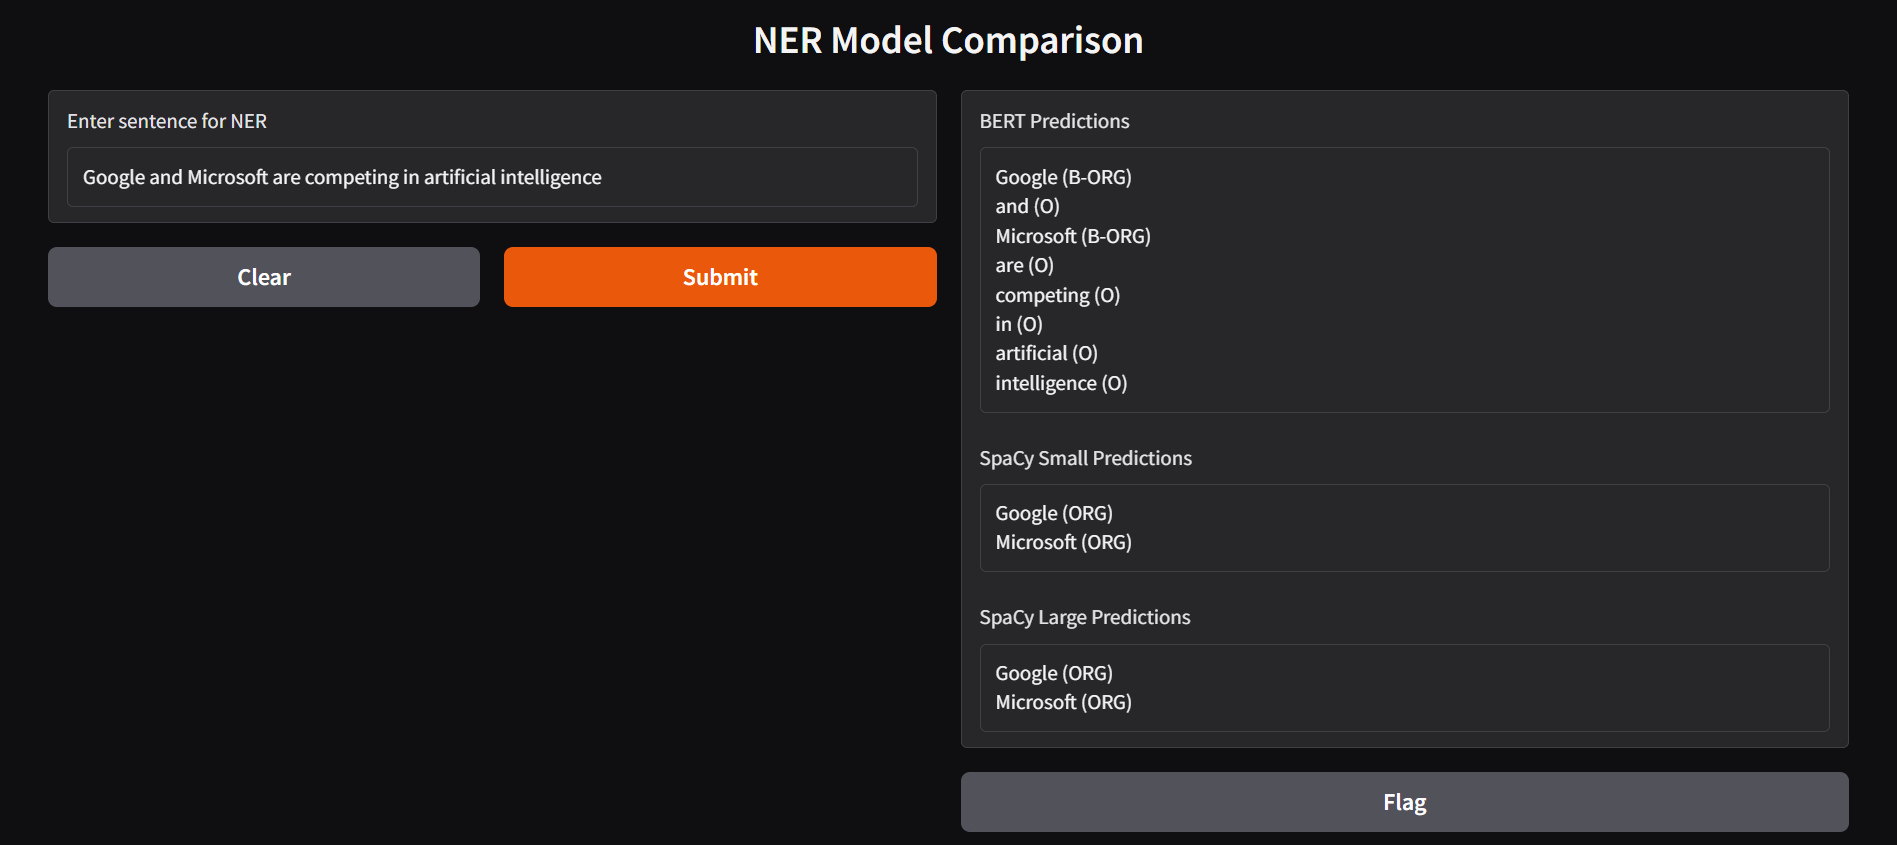

## **The End!**

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
